In [101]:
# Library Import
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from xgboost import XGBClassifier
from category_encoders.target_encoder import TargetEncoder
from scipy.stats import randint
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    RandomizedSearchCV)
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_curve,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report,
    r2_score
)
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import export_graphviz
from datetime import date
from datetime import datetime

def __datetime(date_str):

    if date_str!=date_str:
        date_str=str(date.today())

    return datetime.strptime(date_str, '%Y-%m-%d')

def group_mode(series):
    mode = series.mode()
    if mode.size == 1 and mode[0] == 'Accessories':
        return np.nan
    elif mode.size == 1:
        return mode[0]
    elif mode[0] == 'Accessories': 
        return mode[1]
    else:
        return np.nan

print("Installation Complete!")

Installation Complete!


In [102]:
# Importing and copying raw train data
raw_data = pd.read_csv('/Users/JHache/Downloads/Transactions/train.csv')
data = raw_data.copy(deep=True)


In [103]:
##Feature columns to add:
## Orders with multiple items: CHECK
## Orders with duplicate items of same/diff sizes: CHECK (applies to all duplicate items in order, regardless of size)
## Customer Age Buckets: Check
## clean Consumer group, replace NaNs with mode for "Returns" and "non-Returns" group: CHECK

ordergroup = data.groupby(['OrderID','CustomerID'], as_index=False)
itemgroup = data.groupby(['OrderID','CustomerID','OrderDate','ProductDepartment','ProductCost','PurchasePrice'], as_index=False)
data['order_item_count'] = ordergroup['ID'].transform('count')
data['multi_item_size'] = itemgroup['ProductSize'].transform('count')
data.loc[:, "consumer"] = data.groupby("CustomerID")["ProductDepartment"].transform(group_mode)
data['Consumer_age'] = (__datetime(str(date.today()))-data.CustomerBirthDate.apply(__datetime))/365
data['Consumer_age'] = data.Consumer_age.apply(lambda x: int(str(x).split(" ")[0]) )
data.loc[data['order_item_count'] > 1, 'muti_item_flag'] = 1
data.loc[data['order_item_count'] == 1, 'muti_item_flag'] = 0
data.loc[data['multi_item_size'] > 1, 'multi_size_flag'] = 1
data.loc[data['multi_item_size'] == 1, 'multi_size_flag'] = 0
data['MSRP'] = data['PurchasePrice']/(1.0-data['DiscountPct'])
data['MSRP'] = data['MSRP'].round(2)
data.loc[data['Consumer_age'] <= 20, 'age_group'] = '-20'
data.loc[(data['Consumer_age'] > 20) & (data['Consumer_age'] <= 30), 'age_group'] = '21-30'
data.loc[(data['Consumer_age'] > 30) & (data['Consumer_age'] <= 40), 'age_group'] = '31-40'
data.loc[(data['Consumer_age'] > 40) & (data['Consumer_age'] <= 50), 'age_group'] = '41-50'
data.loc[(data['Consumer_age'] > 50) & (data['Consumer_age'] <= 60), 'age_group'] = '51-60'
data.loc[(data['Consumer_age'] > 60) & (data['Consumer_age'] <= 70), 'age_group'] = '61-70'
data.loc[(data['Consumer_age'] > 70), 'age_group'] = '71+'
data.loc[data['PurchasePrice'] <= 25, 'price_group'] = '-25'
data.loc[(data['PurchasePrice'] > 25) & (data['PurchasePrice'] <= 50), 'price_group'] = '25-50'
data.loc[(data['PurchasePrice'] > 50) & (data['PurchasePrice'] <= 75), 'price_group'] = '51-75'
data.loc[(data['PurchasePrice'] > 75) & (data['PurchasePrice'] <= 100), 'price_group'] = '76-100'
data.loc[(data['PurchasePrice'] > 100) & (data['PurchasePrice'] <= 125), 'price_group'] = '101-125'
data.loc[(data['PurchasePrice'] > 125) & (data['PurchasePrice'] <= 150), 'price_group'] = '126-150'
data.loc[(data['PurchasePrice'] > 150), 'price_group'] = '150+'
data['muti_item_flag'] = data['muti_item_flag'].astype(int)
data['multi_size_flag'] = data['multi_size_flag'].astype(int)

#Imputing 0 values with median for each class
consumer2 = data.groupby(['Returned'], sort=False)['consumer'].apply(lambda x: x.fillna(x.mode().iloc[0]))
data["consumer"] = consumer2.droplevel(0) 


In [104]:
# Creating X and y dataframes for training
X = data.drop(['ID', 'OrderID','CustomerID','CustomerState','CustomerBirthDate','OrderDate','Returned'], axis=1)
y = data['Returned']

Xr = raw_data.drop(['ID', 'OrderID','CustomerID','CustomerState','CustomerBirthDate','OrderDate','Returned'], axis=1)
yr = raw_data['Returned']

In [105]:
# Training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=8)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.2, stratify=y,random_state=8)

In [106]:
# building pipeline for XGBoost Classifier

estimators = [('encoder', TargetEncoder()),
               ('clf', XGBClassifier(booster='gbtree', importance_type='gain',random_state=8))]

pipeL = Pipeline(steps=estimators)
pipeL

Pipeline(steps=[('encoder', TargetEncoder()),
                ('clf',
                 XGBClassifier(base_score=None, booster='gbtree',
                               callbacks=None, colsample_bylevel=None,
                               colsample_bynode=None, colsample_bytree=None,
                               device=None, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=8, ...))])

In [107]:
#optimal hyperparameter tuning
search = {
    'clf__max_depth': Integer(2,8),
    'clf__learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'clf__subsample': Real(0.5, 1.0),
    'clf__colsample_bytree': Real(0.5, 1.0),
    'clf__colsample_bylevel': Real(0.5, 1.0),
    'clf__colsample_bynode' : Real(0.5, 1.0),
    'clf__reg_alpha': Real(0.0, 10.0),
    'clf__reg_lambda': Real(0.0, 10.0),
    'clf__gamma': Real(0.0, 10.0)
}

optimize = BayesSearchCV(pipeL, search, cv=3, n_iter=20, scoring='roc_auc', random_state=8) 
optimizer = BayesSearchCV(pipeL, search, cv=3, n_iter=20, scoring='roc_auc', random_state=8) 
np.int = int
optimize.fit(X_train, y_train)
optimizer.fit(Xr_train, yr_train)

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('encoder', TargetEncoder()),
                                        ('clf',
                                         XGBClassifier(base_score=None,
                                                       booster='gbtree',
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       device=None,
                                                       early_stopping_rounds=None,
                                                       enable_categorical=False,
                                                       eval_metric=None,
                                                       feature_types=None,
                                                       gamma=None,
                                                       grow_policy=None,
                                                       importance_ty...
                             'clf__learning_rate': Real(low=0.001, high=1.0, prior='log-uniform', transform='normalize'),
                             'clf__max_depth': Integer(low=2, high=8, prior='uniform', transform='normalize'),
                             'clf__reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

In [108]:
# Optimized XGBoost Model output
optimize.best_estimator_
xgopt_pred = optimize.predict(X_test)
print(f'best_score: {optimize.best_score_}')
print(f'best_test_score: {optimize.score(X_test, y_test)}')
print(f'Accuracy: {accuracy_score(y_test, xgopt_pred)}')
print(f'Precision:{precision_score(y_test, xgopt_pred)}')
print(f'Recall: {recall_score(y_test, xgopt_pred)}')
print(f'F1 Score: {f1_score( y_test,xgopt_pred, average="weighted")}')
xgboost_pred = optimize.predict_proba(X_test)
xgboostr_pred = optimizer.predict_proba(Xr_test)


best_score: 0.757257884422927
best_test_score: 0.7525050277574217
Accuracy: 0.7423553878148348
Precision:0.649284501576522
Recall: 0.5850087412587412
F1 Score: 0.7390266276216244


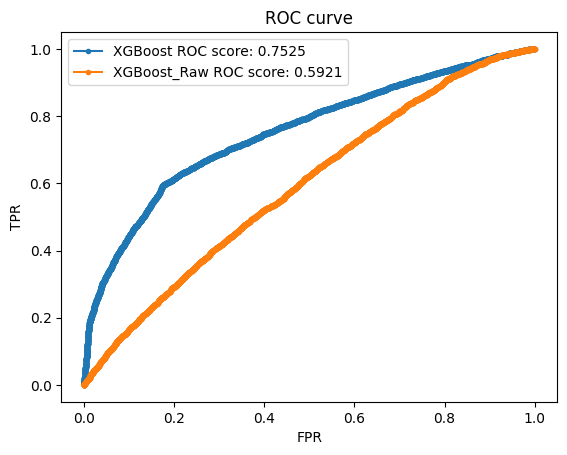

In [109]:
# ROC AUC Score Comparison
xgboost_pred = xgboost_pred[:,1]
xgboostr_pred = xgboostr_pred[:,1]
xgb_auc = roc_auc_score(y_test, xgboost_pred)
xgbr_auc = roc_auc_score(yr_test, xgboostr_pred)
xg_fpr, xg_tpr, _ = roc_curve(y_test, xgboost_pred)
xgr_fpr, xgr_tpr, _ = roc_curve(yr_test, xgboostr_pred)
plt.plot(xg_fpr, xg_tpr, marker='.',label = "XGBoost ROC score: %.4f" % xgb_auc)
plt.plot(xgr_fpr, xgr_tpr, marker='.',label = "XGBoost_Raw ROC score: %.4f" % xgbr_auc)

plt.title("ROC curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

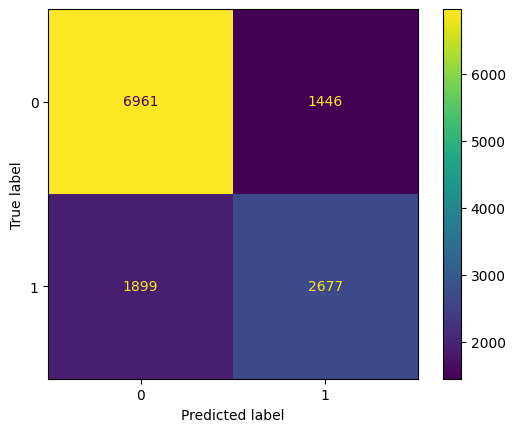

In [110]:
cm = confusion_matrix(y_test, xgopt_pred, labels=optimize.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=optimize.classes_)
disp.plot()

plt.show()


In [111]:
# Importing Test data to run on Optimized XGBoost model
test_data = pd.read_csv('/Users/JHache/Downloads/Transactions/test.csv')
new_data = test_data.copy(deep=True)

In [112]:
##Feature columns to add:
## Orders with multiple items: CHECK
## Orders with duplicate items of same/diff sizes: CHECK (applies to all duplicate items in order, regardless of size)
## Customer Age Buckets: Check
## clean Consumer group, replace NaNs with mode for "Returns" and "non-Returns" group: CHECK

ordergroup = new_data.groupby(['OrderID','CustomerID'], as_index=False)
itemgroup = new_data.groupby(['OrderID','CustomerID','OrderDate','ProductDepartment','ProductCost','PurchasePrice'], as_index=False)
new_data['order_item_count'] = ordergroup['ID'].transform('count')
new_data['multi_item_size'] = itemgroup['ProductSize'].transform('count')
new_data.loc[:, "consumer"] = new_data.groupby("CustomerID")["ProductDepartment"].transform(group_mode)
new_data['Consumer_age'] = (__datetime(str(date.today()))-new_data.CustomerBirthDate.apply(__datetime))/365
new_data['Consumer_age'] = new_data.Consumer_age.apply(lambda x: int(str(x).split(" ")[0]) )
new_data.loc[new_data['order_item_count'] > 1, 'muti_item_flag'] = 1
new_data.loc[new_data['order_item_count'] == 1, 'muti_item_flag'] = 0
new_data.loc[new_data['multi_item_size'] > 1, 'multi_size_flag'] = 1
new_data.loc[new_data['multi_item_size'] == 1, 'multi_size_flag'] = 0
new_data['MSRP'] = new_data['PurchasePrice']/(1.0-new_data['DiscountPct'])
new_data['MSRP'] = new_data['MSRP'].round(2)
new_data.loc[new_data['Consumer_age'] <= 20, 'age_group'] = '-20'
new_data.loc[(new_data['Consumer_age'] > 20) & (new_data['Consumer_age'] <= 30), 'age_group'] = '21-30'
new_data.loc[(new_data['Consumer_age'] > 30) & (new_data['Consumer_age'] <= 40), 'age_group'] = '31-40'
new_data.loc[(new_data['Consumer_age'] > 40) & (new_data['Consumer_age'] <= 50), 'age_group'] = '41-50'
new_data.loc[(new_data['Consumer_age'] > 50) & (new_data['Consumer_age'] <= 60), 'age_group'] = '51-60'
new_data.loc[(new_data['Consumer_age'] > 60) & (new_data['Consumer_age'] <= 70), 'age_group'] = '61-70'
new_data.loc[(new_data['Consumer_age'] > 70), 'age_group'] = '71+'
new_data.loc[new_data['PurchasePrice'] <= 25, 'price_group'] = '-25'
new_data.loc[(new_data['PurchasePrice'] > 25) & (new_data['PurchasePrice'] <= 50), 'price_group'] = '25-50'
new_data.loc[(new_data['PurchasePrice'] > 50) & (new_data['PurchasePrice'] <= 75), 'price_group'] = '51-75'
new_data.loc[(new_data['PurchasePrice'] > 75) & (new_data['PurchasePrice'] <= 100), 'price_group'] = '76-100'
new_data.loc[(new_data['PurchasePrice'] > 100) & (new_data['PurchasePrice'] <= 125), 'price_group'] = '101-125'
new_data.loc[(new_data['PurchasePrice'] > 125) & (new_data['PurchasePrice'] <= 150), 'price_group'] = '126-150'
new_data.loc[(new_data['PurchasePrice'] > 150), 'price_group'] = '150+'
new_data['muti_item_flag'] = new_data['muti_item_flag'].astype(int)
new_data['multi_size_flag'] = new_data['multi_size_flag'].astype(int)

new_data.head()

,ID,OrderID,CustomerID,CustomerState,CustomerBirthDate,OrderDate,ProductDepartment,ProductSize,ProductCost,DiscountPct,...,Returned,order_item_count,multi_item_size,consumer,Consumer_age,muti_item_flag,multi_size_flag,MSRP,age_group,price_group
0,a6f6ecd9-2c08-4363-baf7-b54adc35d486,ad944d45-a857-4156-ac31-6d0eeb8a4bb7,49d38db8-e5f6-45a6-bbc1-6c6ed1f0214d,South Carolina,1976-10-21,2021-01-01,Accessories,~,19,0.2414,...,NaN,2,1,Mens,47,1,0,45.00,41-50,25-50
1,e819be63-7a98-4e6d-b217-03f9ac8c1d03,cefde178-45a0-406f-becf-31c003430d6f,65d3e42c-158f-4104-8dd2-cd8d1379ecf1,California,1961-10-31,2021-01-01,Mens,M,28,0.2771,...,NaN,6,3,Mens,62,1,1,102.01,61-70,51-75
2,8936a1c6-f5eb-4c78-9636-e693aae49d9f,24d7df06-80b2-416d-85e7-0ce8bd442b3f,5341a19e-27dd-42f9-8f8d-bbb76df99e71,Indiana,1953-11-03,2021-01-01,Womens,XXL,21,0.2665,...,NaN,6,2,Womens,70,1,1,48.00,61-70,25-50
3,68b74b1d-deab-4d93-bfe8-859d450952ef,24d7df06-80b2-416d-85e7-0ce8bd442b3f,5341a19e-27dd-42f9-8f8d-bbb76df99e71,Indiana,1953-11-03,2021-01-01,Womens,XXL,23,0.2305,...,NaN,6,2,Womens,70,1,1,91.99,61-70,51-75
4,657abc10-0b36-49df-b3ae-a1a6b9d1d145,086b01d2-8ab8-424d-8494-284cea56ae92,9efd2c6d-fa30-442a-a99a-d5bb2f284bf6,Oregon,1966-01-10,2021-01-01,Accessories,~,13,0.2621,...,NaN,2,1,Mens,58,1,0,42.00,51-60,25-50


In [113]:
new_x_test = new_data.drop(['ID', 'OrderID','CustomerID','CustomerState','CustomerBirthDate','OrderDate','Returned'], axis=1)

In [114]:
optimize.best_estimator_
test_pred = optimize.predict(new_x_test)
test_proba = optimize.predict_proba(new_x_test)

print(test_pred)
test_proba

[0 1 1 ... 1 0 0]


array([[0.90076447, 0.09923556],
       [0.10861003, 0.89138997],
       [0.35256833, 0.6474317 ],
       ...,
       [0.4707787 , 0.5292213 ],
       [0.7671611 , 0.23283894],
       [0.781112  , 0.21888797]], dtype=float32)

In [115]:
new_data['Returned'] = test_pred[:]
new_data['Prediction'] = test_proba[:,1]
output = new_data[['ID', 'Prediction']].copy()
output.to_csv('Predictions.csv', index=False)
# new_data.to_csv('Predictions_full.csv', index=False)